This notebook is the result of the combined efforts of Anas Ezzakri & Houda Ghallab.

<CENTER>
</br>
<p><font size="5">  Go Board Detection </font></p>
<p><font size="4">  Algorithmic approach </font></p>

</p>
</CENTER>


The following notebooks contains the steps to perform a go board recognition, based mainly on computer vision techniques.

> 1. Corners
> 2. Grid dectection
> 3. Stones recognition
> 4. Sgf file and plotting the board

In [292]:
#imports
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sgfmill import sgf


## I. Corners

In [316]:
image = cv2.imread('image.jpg')

from roboflow import Roboflow
rf = Roboflow(api_key="Uhwq8zNnGlq5BnlPmd6F")
project = rf.workspace().project("go-xoex6")
model = project.version(2).model
#%%
# infer on a local image
res = model.predict(image, confidence=10, overlap=30).json()
# %%
corners = []
for feature in res["predictions"]:
    if feature['class'] == 'corner':
        corners.append((feature['x'], feature['y']))

corners.sort(key=lambda x: x[1])
upper = corners[:2]
lower = corners[2:]
upper.sort(key=lambda x: x[0])
lower.sort(key=lambda x: x[0], reverse=True)
corners = upper + lower

loading Roboflow workspace...
loading Roboflow project...


Persective

In [317]:
input_points = np.array(corners, dtype=np.float32)

output_width, output_height = 600, 600
output_points = np.array([[0, 0], [output_width, 0], [output_width, output_height], [0, output_height]], dtype=np.float32)

perspective_matrix = cv2.getPerspectiveTransform(input_points, output_points)


# %%
transformed_image = cv2.warpPerspective(image, perspective_matrix, (output_width, output_height))

## II. Grid detection

We first start by reading the image.

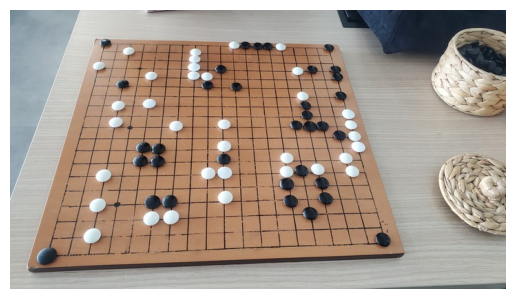

In [318]:
# Convert from BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

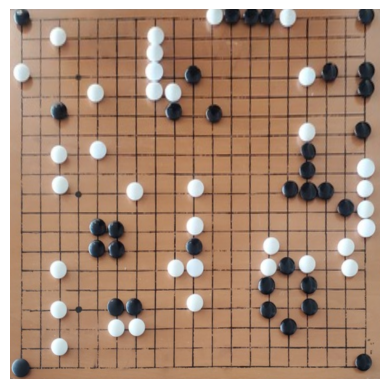

In [319]:
# Convert from BGR to RGB (OpenCV uses BGR by default)
transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(transformed_image)
plt.axis('off')  # Turn off axis labels
plt.show()

We then a apply a series of filers: First the gray filter, Bilateral filter, Laplacien, Canny to get the edges, and finally houghlines to find lines.

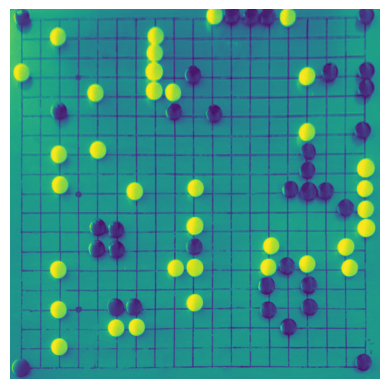

In [323]:
gray = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.axis('off') 
plt.show()

In [298]:
# gray = cv2.bilateralFilter(gray,15,100,100)
# plt.imshow(gray)
# plt.axis('off') 
# plt.show()

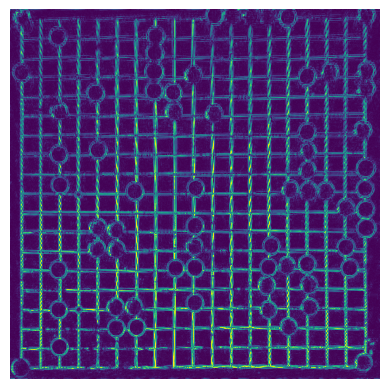

In [321]:
dst = cv2.Laplacian(gray, cv2.CV_16S, ksize=3)
gray = cv2.convertScaleAbs(dst)
plt.imshow(gray)
plt.axis('off') 
plt.show()

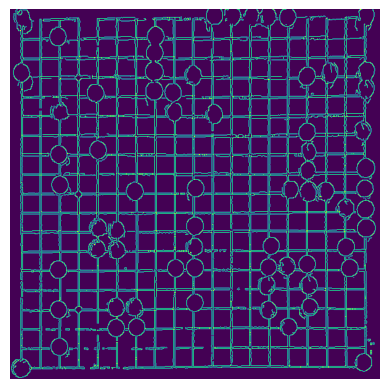

In [324]:
def Canny_(image):
    high_thresh = 150
    lowThresh = 50
    return cv2.Canny(image, lowThresh, high_thresh)

canny = Canny_(gray)
plt.imshow(canny)
plt.axis('off') 
plt.show()

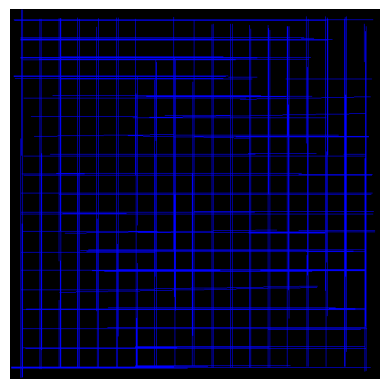

In [325]:
def HoughLinesP_(image, imageToDrawOn=None):
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, threshold=100, minLineLength=20, maxLineGap=40)
    if not imageToDrawOn is None:
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(imageToDrawOn, (x1, y1), (x2, y2), (0, 0, 255), 1)
                
    return lines

houghline = np.zeros_like(transformed_image)
lines = HoughLinesP_(canny, houghline)

plt.imshow(houghline)
plt.axis('off') 
plt.show()

Next, we have to interpolate to complete the resulting lines.

In [326]:
def line_equation(x1, y1, x2, y2):
    if x1 == x2:
        "if slope is infinite , y = x1 = c"
        slope = float('Inf')
        b = x1
    else:
        slope = (y2-y1) / (x2-x1)
        b = y1 - slope * x1
    return slope, b

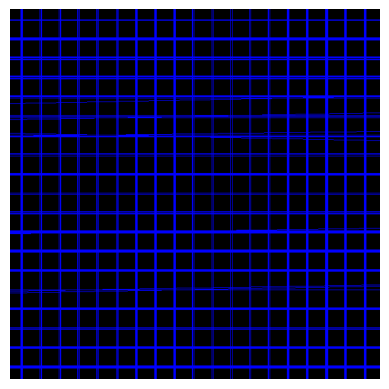

In [327]:
def interpolate(x1, y1, x2, y2):
    "y = slope * x + b"
    slope, b = line_equation(x1, y1, x2, y2)
    if slope == float('Inf'):
        final_bounds = np.array([x1, 0, x1, 600], dtype=np.uint32)
    elif slope == 0:

        final_bounds = np.array([0, y1, 600, y1], dtype=np.uint32)
    else:
        left_bound = (0, b)
        right_bound = (600, int(slope * 600 + b))
        upper_bound = (-b/slope, 0)
        lower_bound = ((600 - b) / slope, 600)
        possible_bounds = [left_bound, right_bound, upper_bound, lower_bound]
        
        final_bounds = np.array([], dtype=np.uint32)
        for bound in possible_bounds:
            x, y = bound
            if x > 600 or x < 0 or y < 0 or y > 600:
                continue
            final_bounds = np.append(final_bounds, (int(x), int(y)))
    return final_bounds

ex = np.zeros_like(transformed_image)
lines = lines.squeeze()

for i in range(len(lines)):
    lines[i] = interpolate(*lines[i])

for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(ex, (x1, y1), (x2, y2), (0, 0, 255), 1)

plt.imshow(ex)
plt.axis('off') 
plt.show()

As we can see, we have lots of duplicated lines overlapping, so we'll clean them by removing similar lines.

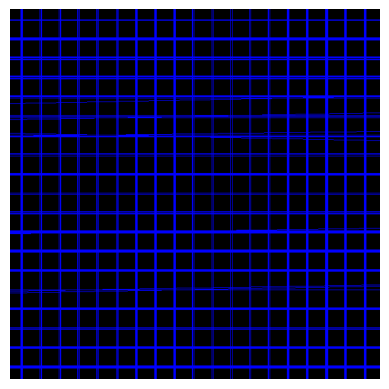

In [328]:
def are_similar(line1, line2):
    return abs(line1[0] - line2[0]) <= 15 and abs(line1[1] - line2[1]) <= 15

def removeDuplicates(lines):
    grouped_lines = {}
    for line in lines:
        x1, y1, x2, y2 = line
        found = False
        for key in grouped_lines.keys():
            if are_similar(key, line):
                grouped_lines[key] = grouped_lines[key] + [line]
                found = True
                break
        if not found:
            grouped_lines[(x1, y1, x2, y2)] = [line]

    final_lines = []
    for key in grouped_lines.keys():
        final_lines.append(grouped_lines[key][0])
    
    return np.array(final_lines)

clean_lines = removeDuplicates(lines)

ex = np.zeros_like(transformed_image)

for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(ex, (x1, y1), (x2, y2), (0, 0, 255), 1)

plt.imshow(ex)
plt.axis('off') 
plt.show()


Now, we have to classify horizontal and vertical lines.

In [329]:

def is_vertical(x1, y1, x2, y2):
    return abs(x1 - x2) < 50 and abs(y1 - y2) > 50

vertical_lines = []
horizontal_lines = []
for line in clean_lines:
    if is_vertical(*line):
        vertical_lines.append(line)
    else:
        horizontal_lines.append(line)

vertical_lines.sort(key=lambda x: x[0])
horizontal_lines.sort(key=lambda x: x[1])

We, then, find the intersections betzeen vertical and horizontal lines

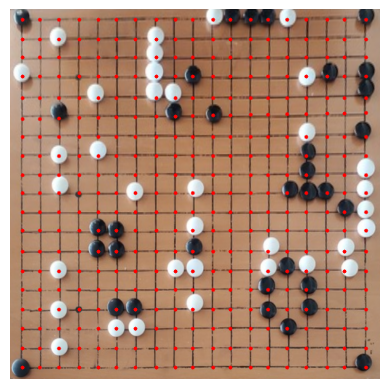

In [330]:

def intersect(line1, line2):
    slope1, b1 = line_equation(*line1)
    slope2, b2 = line_equation(*line2)
    if slope1 == float('Inf'):
        x = b1
        y = slope2 * x + b2
    elif slope2 == float('Inf'):
        x = b2
        y = slope1 * x + b1
    else:
        x = (b2 - b1) / (slope1 - slope2)
        y = slope1 * x + b1
    return int(x), int(y)

copy = transformed_image.copy()
intersections = []
for v_line in vertical_lines:
    for h_line in horizontal_lines:
        inter = intersect(v_line, h_line)
        intersections.append(inter)
        cv2.circle(copy,inter,3,255,-1)

plt.imshow(copy)
plt.axis('off') 
plt.show()


## III. Stones recognition

To find the stones on a go board, we used a part of the watershed algorithm. We relied on the sure foreground area to determine the number and the positions of stones.

First, we define this RgbInv class, that inverses the colors of white and black stones, makes the board black, and the grid lines white. This is necessary because when testing the watershed algorithm, we found out that it only detects white stones since this algorithm relies on find local minima in an image.

In [331]:
transformed_image_url = "transformed_image.jpg"

In [332]:
class RgbInv:
    def __init__(self, image):
        
        # #load the image
        # self.image = cv2.imread(image_url)
        self.image = image
        #convert to rgb
        self.rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #iterate over pixels
    
    def detect(self):
        
        if self.image is not None:
            
            # Get the height and width of the image
            height, width, channels = self.image.shape

            #initialize the detected image
            detected_image = np.zeros_like(self.image)
            
            #define the color margin/error
            err_black = 160
            err_white = 130
            err_green = 80
            
            for y in range(height):
                for x in range(width):
                    # Get the BGR color values of the pixel
                    blue, green, red = self.image[y, x]
                    
                    #compare the colors of the original image
                    if np.linalg.norm(np.array([blue, green, red]) - np.array([0, 0, 0])) < err_black:
                        detected_blue, detected_green, detected_red = 255, 255, 255
                    elif np.linalg.norm(np.array([blue, green, red]) - np.array([255, 255, 255])) < err_white:
                        detected_blue, detected_green, detected_red  = 0, 0, 0
                    # elif np.linalg.norm(np.array([blue, green, red]) - np.array([17, 242, 39])) < err_green:
                    #     detected_blue, detected_green, detected_red  = 17, 242, 39
                    else:
                        detected_blue, detected_green, detected_red  = 0, 0, 0

                    #reconstruct the detected image with the newly assigned colors
                    detected_image[y, x] = detected_blue, detected_green, detected_red
    
        return detected_image

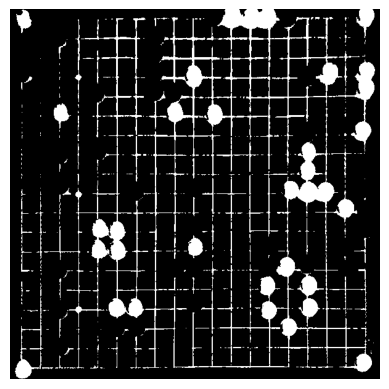

In [333]:
img_black = RgbInv(transformed_image)
img_detected = img_black.detect()

plt.imshow(img_detected)
plt.axis('off') 
plt.show()


Next, we defined the class Stones which detects the present stones on the board

In [334]:
class Stones:
    def __init__(self, img):
        self.img = img
        # read input image to detect white stones
        img_white = img

        #read the inverted image to detect black stones
        img_black = RgbInv(img)
        img_black = img_black.detect()

        #initialize the parameters
        self.white_image = img_white
        self.black_image = img_black
    
    def detect_stones(self):
        
        #convert image to binary
        def binary(img):
            # convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # threshold to binary
            thresh = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY)[1]

            return gray, thresh

        #extract the areas that we are sure they are stones
        def areas(thresh):
            # noise removal
            kernel = np.ones((3,3),np.uint8)
            opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 6)
            # sure background area
            sure_bg = cv2.dilate(opening,kernel,iterations=3)
            # Finding sure foreground area
            dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
            ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)
            # Finding unknown region
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg,sure_fg)
            return sure_fg

        def positions(sure_fg):
            positions = []
            numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(sure_fg,  4, cv2.CV_32S)
            # loop over the number of unique connected component labels
            for i in range(0, numLabels):
                (cX, cY) = centroids[i]
                # append the position (center of the component) to the position list
                positions.append((cX,cY))
            return positions
    
        #get the parameters
        _ , white_thresh = binary(self.white_image)
        white_sure_fg = areas(white_thresh)

        #find the position
        #we remove the first element because it represents the background and not an actual stone
        white_stones_positions = positions(white_sure_fg)[1:]
        
        #get the parameters
        _ , black_thresh = binary(self.black_image)
        black_sure_fg = areas(black_thresh)

        #find the position
        black_stones_positions = positions(black_sure_fg)[1:]

        return white_stones_positions, black_stones_positions
    

In [335]:
stones = Stones(transformed_image)
white_stones, black_stones = stones.detect_stones()

Let's visualise the results:

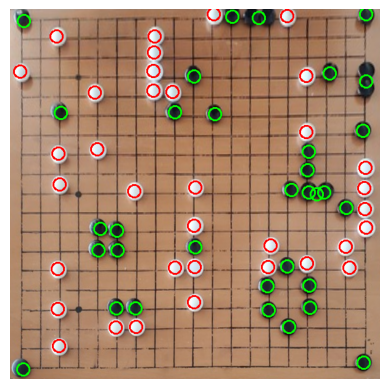

In [337]:
test = np.copy(transformed_image)

for stone in white_stones:
    cv2.circle(test, np.array(stone).astype(dtype=int), 10, (255, 0, 0), 2)

for stone in black_stones:
    cv2.circle(test, np.array(stone).astype(dtype=int), 10, (0, 255, 0), 2)

plt.imshow(test)
plt.axis('off') 
plt.show()

## IV. Sgf file and plotting the board

To create the sgf file, we defined the class GoSgf that initialize the sgf file, allows us to update the file move ny move or create the file with a list of ordered moves.

In [338]:
            
class GoSgf:
    """
    class GoSgf: 
    creates an sgf file given the list of moves (stones and their positions) extracted from the image recognition part
    """

    def __init__(self, black:str, white:str, tournament:str=None, date:str=None):
        """"
        Constructor method for GoSgf.

        Parameters:
        -----------
        black : str
            name of the black player
        white : str
            name of the white player
        moves : list
            a list of the played moves
        tournament : str
            tournament in which the game was played, can be attributed "training"
        date : str
            date in which the game was played
        """
        # define the game information
        self.black = black
        self.white = white
        self.board_size = (19,19)
        self.tournament = tournament

        self.game_info = {
            "EV" : tournament,
    	    "RO" : "1",
            #"GM" : "1", #game type, 1 for go
            "PB" : black,
            "PW" : white,
            #"SZ" : f"{self.board_size[0]}",
            "KM" : "6.5", #komi
            #"RU" : "Japanese" #rules used
            "DT" : date
        }

        #get the moves we collected from board recognition
        self.moves = []

    def update_sgf(self, move):
        """
        Add a move to the game and update the SGF file.

        Parameters:
        -----------
        player : str
            Player color ('B' for black, 'W' for white)
        position : tuple
            Tuple representing the (x, y) coordinates of the move
        """
        player, position = move
        self.moves.append((player, position))
        sgf_content = self.assembleSgf()

        sgf_filename = f"{self.black}_{self.white}.sgf"
        with open(sgf_filename, "w") as sgf_file:
            # Write game information
            sgf_file.write("(; \n")
            for key, value in self.game_info.items():
                sgf_file.write(f"{key}[{value}]\n")
            sgf_file.write("\n")

            # Write stone positions
            sgf_file.write(sgf_content)

            # End the SGF file
            sgf_file.write(")\n")
        
        return sgf_file, sgf_filename


    # ... (your existing methods)
    
    #convert a move to SGF format
    def add_to_sgf(self, move):
        """
        Add a move to the sgf file

        Returns:
        --------
        str
            one move composed of the player, the letter corresponding to the x coordinate, and the letter corresponding to the y coordinate
        """
        player, position = move
        x, y = position 
        sgf_x = chr(ord('a') + x)
        sgf_y = chr(ord('a') + y)
        return f";{player}[{sgf_x}{sgf_y}]"
        
    #convert the sgf file 
    def assembleSgf(self):
        """
        Put together and write the sgf file and save it

        Returns:
        --------
        sgf
            the sgf file of the game

        str
            The name of the sgf file
        """
        sgf_ = ''.join([self.add_to_sgf(move) for move in self.moves])
        return sgf_
    

    def createSgf(self, moves):
        """
        Create and Write the sgf file

        Returns:
        --------
        sgf_file : sgf
            the sgf file of the game
        sgf_filename : str
            name of the sgf file
        """
        self.moves = moves
        sgf_moves = self.assembleSgf()
        sgf_filename = f"{self.black}_{self.white}.sgf"
        
        with open(sgf_filename, "w") as sgf_file:

            # Write game information
            sgf_file.write("(; \n")
            for key, value in self.game_info.items():
                sgf_file.write(f"{key}[{value}]\n")
            sgf_file.write("\n")

            # Write stone positions
            sgf_file.write(sgf_moves)

            # End the SGF file
            sgf_file.write(")\n")

        return sgf_file, sgf_filename
    
    

After we found the stones, we assign each stone to the closest intersection

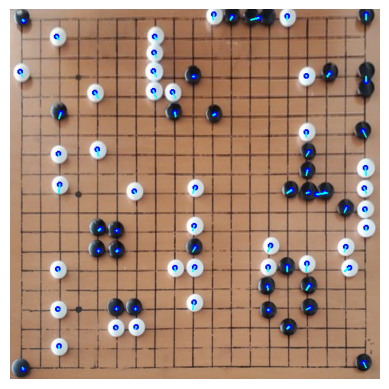

In [347]:
def create_board(intersections, board_size=(19,19)):
    cleaned_intersections = []
    for inter in intersections:
        if inter[0] > 5 and inter[0] < 595 and inter[1] < 595 and inter[1] > 5:
            cleaned_intersections.append(inter)
    
    
    cleaned_intersections.sort(key=lambda x: (x[1], x[0]))
    
    board = {}
    for j in range(board_size[1]):
        for i in range(board_size[0]):
            if len(cleaned_intersections) != 0:
                board[tuple(np.round(cleaned_intersections.pop(0)).astype(dtype=int))] = (i, j)
    
    return board

copy = np.copy(transformed_image)
Board = create_board(intersections)
moves = []


for stone in white_stones:
    cv2.circle(copy, np.array(stone).astype(dtype=np.int32), 3, (0, 0, 255), 2)
    nearest_corner = None
    closest_distance = 100000
    for inter in intersections:
        distance = math.dist(inter, stone)
        if distance < closest_distance:
            nearest_corner = tuple(np.round(inter).astype(dtype=int))
            closest_distance = distance
    moves.append(("W", (Board[nearest_corner][0], 18 - Board[nearest_corner][1])))
    cv2.line(copy, (int(stone[0]), int(stone[1])), (int(nearest_corner[0]), int(nearest_corner[1])), (0, 255, 255), 2)
        
for stone in black_stones:
    cv2.circle(copy, np.array(stone).astype(dtype=np.int32), 3, (0, 0, 255), 2)
    nearest_corner = None
    closest_distance = 100000
    for inter in intersections:
        distance = math.dist(inter, stone)
        if distance < closest_distance:
            nearest_corner = tuple(np.round(inter).astype(dtype=int))
            closest_distance = distance
        
    moves.append(("B", (Board[nearest_corner][0], 18 - Board[nearest_corner][1])))
    cv2.line(copy, (int(stone[0]), int(stone[1])), (int(nearest_corner[0]), int(nearest_corner[1])), (0, 255, 255), 2)

plt.imshow(copy)
plt.axis('off') 
plt.show()


In [344]:
fichier = GoSgf("ex", "ex")
sgf_file, sgf_filename = fichier.createSgf(moves)

Next, to draw the board, we defined the GoBoard class. It labels the last played move in red, and allows navigation in the sgf file, like accessing to the previous or the next positions

In [345]:
class GoBoard:
    """
    class Goboard: 
    creates a board given an sgf file provided by the GoSgf class
    can navigate through the game using methods such as previous or next
    """

    def __init__(self, sgf_url:str):
        """"
        Constructor method for GoBoard.

        Parameters:
        -----------
        sgf_url : str
            directory of the sgf file
        """
        with open(sgf_url, 'rb') as f:
            sgf_content = f.read()

        # Load an sgf file/ the game
        self.sgf_game = sgf.Sgf_game.from_bytes(sgf_content)
        
        #get the game size
        self.board_size = self.sgf_game.get_size()

        # Extract the game moves
        self.moves = []
        for node in self.sgf_game.get_main_sequence():
            color, move = node.get_move()
            if color is not None and move is not None:
                row, col = move
                self.moves.append((row, col, color)) 

        # Get the number of moves 
        self.total_number_of_moves = len(self.moves)

        # Define the current number of moves initialized by the total number, and which we'll modify each time whne calling the previus or the next fucntion
        self.current_number_of_moves = self.total_number_of_moves
        
       
    def drawBoard(self, number_of_moves_to_show : int):
        """
        Draw the board up to a certain number of moves

        Parameters:
        -----------
        number_of_moves_to_show : int
            Define moves we want to plot on the board

        Returns:
        --------
        numpy array
            The resulted board 
        """
        square_size = 30
        circle_radius = 12
        
        #set up the board's background
        board =np.full(((self.board_size+1)*square_size, (self.board_size+1)*square_size, 3), (69, 166, 245), dtype=np.uint8)
        board2 = np.zeros((self.board_size, self.board_size))

        #extract the moves we wanna show
        extracted_moves = self.moves[:number_of_moves_to_show]
        
        # Draw lines for the board grid
        
        # for i in range(board_size):
        #     ax.plot([i, i], [0, board_size - 1], color='k', linewidth = 0.7)
        #     ax.plot([0, board_size - 1], [i, i], color='k', linewidth = 0.7)
        
        for i in range(1, self.board_size+1):
            # Vertical lines and letters
            cv2.line(board, (square_size*i, square_size), (square_size*i, square_size*(self.board_size)), (0, 0, 0), thickness=1)
            #plt.text(i, -0.8, chr(97 + i), fontsize=8, color='black')    
            cv2.putText(board, str(i), (square_size*i, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=1)
            # Horizontal lines and letters
            cv2.line(board, (square_size, square_size*i), (square_size*(self.board_size), square_size*i), (0, 0, 0), thickness=1)
            #plt.text(-0.8, i, chr(97 + i), fontsize=8, color='black')  
            cv2.putText(board, str(i), (5, square_size*i), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=1)
        # Draw stones
        for move in extracted_moves:
            row, col, color = move
            if board2[row, col] == 0:
                stone_color = (0, 0, 0) if color == 'b' else (255, 255, 255)
                board2[row, col] = 1
                cv2.circle(board, ((col+1)*square_size, (row+1)*square_size), circle_radius, color=(66, 66, 66), thickness=2) # draw the edge
                cv2.circle(board, ((col+1)*square_size, (row+1)*square_size), circle_radius, color=stone_color, thickness=-1) # draw the stone
        
        #setting the contour of the last move to a different color
        last_move = extracted_moves[-1]           
        stone_color = (0,0,0) if last_move[2] == 'b' else (255, 255, 255)
        cv2.circle(board, ((last_move[1]+1)*square_size, (last_move[0] + 1)*square_size), circle_radius, color=(0,0,255), thickness=2) 
        cv2.circle(board, ((last_move[1]+1)*square_size, (last_move[0] + 1)*square_size), circle_radius, color=stone_color, thickness=-1) 

        return board

    
    
    def initial_position(self):
        """
        Display the initial position with the first move

        Returns:
        --------
        numpy array
            The resulted board drawn with only the first played move
        """
        self.current_number_of_moves = 1
        return self.drawBoard(1)

    def final_position(self):
        """
        Display the final position 

        Returns:
        --------
        numpy array
            The resulted board drawn with all the played moves 
        """
        self.current_number_of_moves = self.total_number_of_moves
        return self.drawBoard(self.total_number_of_moves)

    def current_position(self):
        """
        Display the current position

        Returns:
        --------
        numpy array
            The resulted board drawn with all the played moves up to the current instant
        """
        return self.drawBoard(self.current_number_of_moves)

    def current_turn(self):
        """
        Display whose turn to play

        Returns:
        --------
        string
            The color of the current turn
        """
        turn = self.moves[self.current_number_of_moves - 1][2]
        if turn == 'b':
            return 'White' 
        elif turn == 'w' or self.current_number_of_moves == 0:
            return 'black'
        
    def previous(self):
        """
        Display the previous position

        Returns:
        --------
        numpy array
            The board one move before the displayed position
        """
        if self.current_number_of_moves > 1:
            self.current_number_of_moves -= 1
            return self.drawBoard(self.current_number_of_moves)

    def next(self):
        """
        Display the next position

        Returns:
        --------
        numpy array
            The board one move after the displayed position
        """
        if self.current_number_of_moves < self.total_number_of_moves:
            self.current_number_of_moves += 1
            return self.drawBoard(self.current_number_of_moves)

Final result

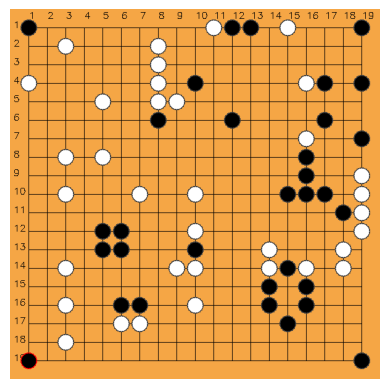

In [346]:
board = GoBoard(sgf_filename)
res = board.final_position()
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

plt.imshow(res)
plt.axis('off') 
plt.show()